# OCR (Misc)

> Train our neural network to read handwritten letters! I'm sure with the newest technological advances, you'll be able to do it with a tiny network and just a handful of training images.
> 
> [Attachment](https://storage.googleapis.com/gctf-2022-attachments-project/5012b41c4d1ffefe9a52759d20d213a1e93104bdce67f435d901dc231b8aa1e158e314b018a179afcc42c4876637b792463882b4cfd22a6a89b16722eebb81a7)
> 
> `ocr.2022.ctfcompetition.com 1337`
> 
> 47 solves, 208 points

The attachment defines a simple neural network model that takes in a 16 x 16 RGB image and outputs 128 classes for ascii characters.

```python
# server.py
model = Sequential()
model.add(Flatten(input_shape=(16,16,3)))
# I'm sure we can compress it all down to four numbers.
model.add(Dense(4, activation='relu'))
model.add(Dense(128, activation='softmax'))
```

The challenge description hints at actually training a model to get weights that properly classifies text in the images, however:

- We don't have enough training data to know what colors / font / etc. the flag looks like
- The architecture is very limited with only 4-wide hidden layer (even the simplest 2-layer MNIST nets use around 300 nodes)
- A single ReLU layer is not enough non-linearity to model functions well

Since we have very granular control over model weights, we can instead try to leak the image data by making the output look very specifically at one pixel at a time.

We can first create a local instance of the model to see what weights we can manipulate.

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(16,16,3)))
model.add(Dense(4, activation='relu'))
model.add(Dense(128, activation='softmax'))

wt = model.get_weights()
for i, n in zip(wt, ["Dense (image => hidden)", "Hidden layer bias", "Dense (hidden => output)", "Softmax bias"]):
    print(n, ":", i.shape)

Dense (image => hidden) : (768, 4)
Hidden layer bias : (4,)
Dense (hidden => output) : (4, 128)
Softmax bias : (128,)


I decided to use this strategy:

- Query once for each channel of each pixel by connecting one node of image input to all 4 hidden nodes
- Offset each hidden node with a different negative bias, acting as a "cutoff" once the ReLU is called
- Connect each output of "1" to "4" with a positive coefficient to its respective hidden node and a heavy negative coefficient to the hidden node right after
- Adding a constant bias for all hidden nodes from "1" to "4" so that the softmax will ignore other labels

This way, depending on how bright a pixel is, different sets of hidden layer and output layer will be activated. We can thus leak slightly more than 2 bits of color information with one query by classifying brightness across 5 output values (taking output of "?" to mean "0").

We can simulate the output with some numpy below.

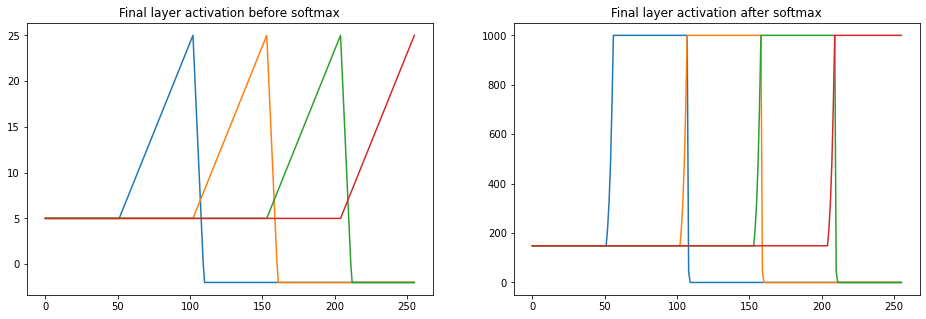

In [11]:
import numpy as np
import matplotlib.pyplot as plt

inputs = np.arange(0, 256) / 255
inputs = inputs.astype(np.float32)

cutoffs = [0.2, 0.4, 0.6, 0.8]
hidden = [
    np.clip(inputs - cutoff, 0, 1)
    for cutoff in cutoffs
]

denses = [
    [2, -20, 0, 0],
    [0, 2, -20, 0],
    [0, 0, 2, -20],
    [0, 0, 0, 2]
]
scale = 50
biases = [5, 5, 5, 5]

outputs = [
    np.clip((sum(i * j for i, j in zip(dense, hidden)) * scale + bias), -2, 1000)
    for dense, bias in zip(denses, biases)
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.set_title("Final layer activation before softmax")
for i in outputs:
    ax1.plot(i)

outputs = [
    np.clip(np.exp(i), 0, 1000)
    for i in outputs
]

ax2.set_title("Final layer activation after softmax")
for i in outputs:
    ax2.plot(i)

With some helper functions to bootstrap the neural net and update which pixel and channel is being sampled, we can start to leak the image data.

In [12]:
from pwn import *
from tqdm.auto import tqdm

context.log_level = "error"

# Avoid wasting time in .recvuntil
FAST = True
r = None

def new_remote():
    # # local testing
    # r = process(["python3", "./localrun.py"])
    # return r

    r = remote("ocr.2022.ctfcompetition.com", 1337)
    r.recvuntil(b"kctf-pow) solve ")

    chal = r.recvline().decode().strip()
    print(chal)
    chal_r = process(["python3", "pow.py", "solve", chal])
    chal_r.recvline()
    soln = chal_r.recvall().strip().decode()
    print(soln)
    r.sendline(soln.encode())
    return r

def menu():
    if FAST:
        r.clean()
        return
    r.recvuntil(b"3. Quit\n")

def clear_weights():
    menu()
    r.sendline(b"0")

def set_weight(*data):
    menu()
    r.sendline(b"1")
    if not FAST:
        r.recvuntil(b"and weight value:\n")
    idx, val = [int(i) for i in data[:-1]], float(data[-1])
    req = " ".join([str(i) for i in idx] + [str(val)])
    r.sendline(req.encode())

def read_flag():
    menu()
    r.sendline(b"2")
    r.recvuntil(b"The neural network sees:")
    res = r.recvline().split(b"'")[1].decode()
    return res

In [13]:
output_base = ord("1")

def setup_leak():
    clear_weights()

    for idx, cutoff in enumerate(cutoffs):
        set_weight(1, idx, -cutoff)

    for output_idx, dense_coefs in enumerate(denses):
        for hidden_idx, dense_coef in enumerate(dense_coefs):
            if dense_coef == 0:
                continue
            set_weight(2, hidden_idx, output_idx + output_base, dense_coef * scale)
    
    for output_idx, bias in enumerate(biases):
        set_weight(3, output_idx + output_base, bias)

last_selected_pixel = None
def select_pixel(idx):
    global last_selected_pixel
    if last_selected_pixel is not None:
        for i in range(4):
            set_weight(0, last_selected_pixel, i, 0)
    for i in range(4):
        set_weight(0, idx, i, 1)
    last_selected_pixel = idx

In [14]:
import json

DATA_READY = True
if not DATA_READY:
    # This takes around 11 minutes
    leaked_data = {}

    workload = list(range(16 * 16 * 3))
    for workload_start in range(0, len(workload), 200):
        workload_slice = workload[workload_start:workload_start + 200]

        r = new_remote()
        setup_leak()
        for i in tqdm(workload_slice):
            select_pixel(i)
            leaked_data[i] = read_flag()

    with open("ocr_leaked_data.json", "w") as f:
        json.dump(leaked_data, f)

with open("ocr_leaked_data.json", "r") as f:
    leaked_data = json.load(f)
    leaked_data = {
        int(k): v
        for k, v in leaked_data.items()
    }

print("First pixel", leaked_data[0])

First pixel 13?42422???321344???2332132121??4?


Finally, we regenerate the image.

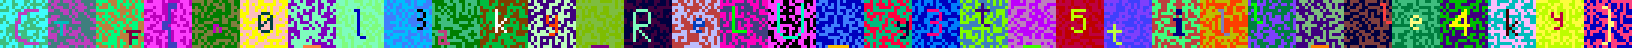

In [15]:
from PIL import Image

flag_len = len(leaked_data[0])
img = np.zeros([16, 16 * flag_len, 3], np.uint8)

for k, v in leaked_data.items():
    cur = k
    channel, cur = cur % 3, cur // 3
    x, cur = cur % 16, cur // 16
    y = cur
    for idx, px in enumerate(v):
        dx = 16 * idx + x
        val = int(px.replace("?", "0")) * 63
        img[y][dx][channel] = val

Image.fromarray(img, "RGB").resize((48 * flag_len, 48), Image.NEAREST)

To make things easier, we can also mask the least common color in each 16 by 16 square.

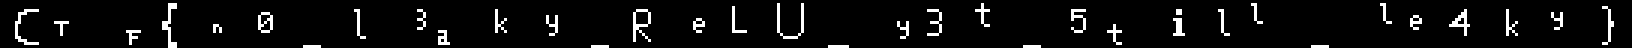

In [16]:
from collections import Counter

mask_img = img.copy()
for i in range(flag_len):
    ctr = Counter()
    for x in range(i * 16, (i + 1) * 16):
        for y in range(16):
            px = tuple(mask_img[y, x])
            ctr[px] += 1
    flag_color = ctr.most_common(3)[-1][0]
    for x in range(i * 16, (i + 1) * 16):
        for y in range(16):
            px = tuple(mask_img[y, x])
            if flag_color == px:
                mask_img[y, x, :] = [255, 255, 255]
            else:
                mask_img[y, x, :] = [0, 0, 0]

Image.fromarray(mask_img, "RGB").resize((48 * flag_len, 48), Image.NEAREST)

We get the flag `CTF{n0_l3aky_ReLU_y3t_5till_le4ky}`.